# Explainer Notebook - Network Analysis
> "This section describes the in detail analysis done in this project."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [explainer notebook, in depth analysis]
- image: images/some_folder/your_image.png
- hide: true
- search_exclude: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2


This notebook is going to dive into the full network analysis done in this project. This includes some basic stats of the network, how the interactive network visualization are created and further some properties of the network. 

How the network is generated and how the information is extracted from the Game Of Thrones wiki-page is described in section 2.1.1 *Data extraction, cleaning and preprocessing* in the Explainer Notebook. 

We will start out by importing the needed packages for performing the network analysis. 

In [1]:
import networkx as nx
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import json
import requests
import os
import contextlib
import powerlaw
import plotly.graph_objects as go


As the network have been saved in a `gpickle` file we can just load it in:

In [2]:
G = nx.read_gpickle("../data/got_G.gpickle")

The network we are mainly investigating is the full network based on all the information from each character page and not the separate networks for each season as these are often quite small. 

<h1 align = "center"> 1. Basic stats of graph </h1>

---

Having loaded the network we will start out by investigating some basic stats of the network. If you want to look into the basic statistics behind the data you can look at section 2.2.1 *Basic Statistics* in the Explainer Notebook. 

Lets start out by determining the size of the network with respect to number of nodes and edges ie. characters and links. Each node represents a character and has some assigned attributes namely: allegiance, religion, culture, status (dead, alive, uncertain) and number of appearances. Each link between two nodes are determined by the linking between the wiki-pages and if these links are directed. Further, each link has a frequency describing the number of occurences this specific link has. 




In [3]:
print(f'The network contains: {G.number_of_nodes()} nodes and {G.number_of_edges()} number of edges.')

The network contains: 162 nodes and 3085 number of edges.


The network contains 162 nodes ie. 162 characters and 3085 edges. This means that the network is very dense. One would start to look into whether all nodes are connected in one Giant Component or it contains some smaller networks. 

We can use the `weakly_connected_components` to find the clusters in the network and then use `subgraph` to extract the largest component. 



In [4]:
GCC = G.subgraph(max(nx.weakly_connected_components(G),key=len))
print(f'The GCC contains: {GCC.number_of_nodes()} nodes and {GCC.number_of_edges()} number of edges.')

The GCC contains: 162 nodes and 3085 number of edges.


We notice that the network are the same, and this means we have a very dense network with all characters being connected. 

<h2 align = "center"> 1.1 Average shortest path </h2>

Having determined that the network is very dense and the starting network also are the GCC, we are going to determine the average shortest path using the `average_shortest_path_length` function. 

In [5]:
print(f'Average shortest path is: {round(nx.average_shortest_path_length(G),3)}')

Average shortest path is: 2.162


The average shortest path is just above two, which means that the average distance is only 2 steps, which again indicates how dense the network is. 

<h2 align = "center"> 1.2 In- and out degree </h2>

We are starting out by examining the degree distribution of the network, as the network is a directed network this would include both the in degree and out degree distribution. The in-degree is the number of inward edges from a node to the given node and vice versa for the out-degree. The degree describes the number of edges, and can contain information describing the characters connectiveness in the network. 

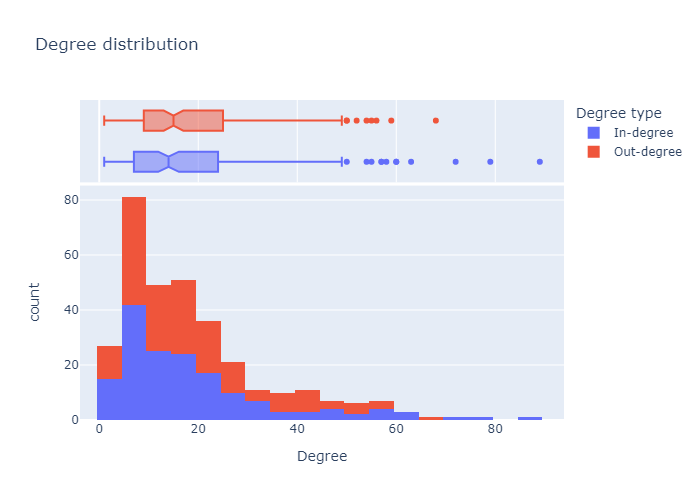

In [6]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

df = pd.DataFrame({
    "Degree" : np.concatenate((in_degrees,out_degrees)),
    "Degree type" : np.concatenate((["In-degree"]*len(in_degrees), ["Out-degree"]*len(out_degrees))),
})

#Compute in- and out degree of nodes having role == Ally
in_degrees = [[n,G.in_degree(n)] for n, d in G.nodes(data = True)]
out_degrees= [[n,G.out_degree(n)] for n, d in G.nodes(data = True)]

#Sort and select only top 5 most connected:
top5_in_degrees = sorted(in_degrees, key = lambda i: i[1], reverse = True)
top5_out_degrees= sorted(out_degrees, key = lambda i: i[1], reverse = True)

fig = px.histogram(df, x="Degree",color = 'Degree type', marginal="box", title = "Degree distribution")
fig.show()

From the figure above it can be seen that the in-degree and out-degree distribution are very similar, and appears to come from the same distribution. It should be noted from both the histogram and the boxplot that the in-degree distribution has more extreme point but at the same time has a lower median. Further it can be seen that the out-degree (ie. outgoing links) appear to have a higher peak around 5-9 degree compared to in-degree. It should also be noticed that the network is very dense, and all characters have at least a couple of other characters they interact with. From the degree distribution we can find the top-5 most connected characters based on in- and out-degree which is presented in the tables below. 

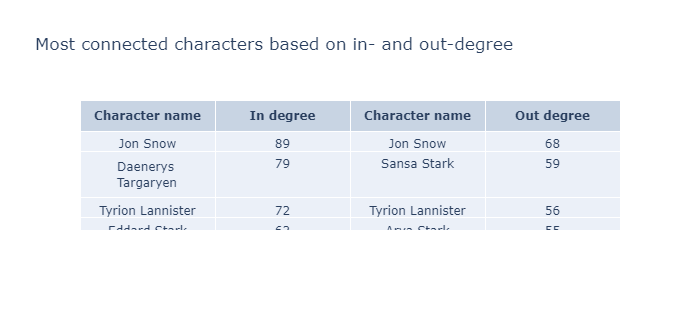

In [7]:
#hide_input
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Character name</b>', '<b>In degree</b>','<b>Character name</b>', '<b>Out degree</b>']),
                 cells=dict(values=[
                     [name[0].replace('_',' ') for name in top5_in_degrees], 
                     [name[1] for name in top5_in_degrees],
                     [name[0].replace('_', ' ') for name in top5_out_degrees], 
                     [name[1] for name in top5_out_degrees]]))
                     ])
fig.update_layout(
    height=310,
    showlegend=False,
    title_text = "Most connected characters based on in- and out-degree"
)

fig.show()

From the table above it appears that *Jon Snow* is the most connected character based on in-degree. Also it should be noted that all five characters are main characters in Game Of Thrones, and therefore it would make sense that they are well connected in the network. Further, all but *Eddard Stark* are characters that are appearing in most episodes (see [Basic Statistics](https://mikkelmathiasen23.github.io/GameOfThrones_Network/02_Basic_Statistics/)). 

*Eddark Stark* dies quite early in the series, and it might be a surprise that he is one of the most connected characters, but as this is based on in-degree this could be due to many of the others characters pages references Eddard. This would make sense as his children probably talks about him/mentions him and therefore make him very connected compared to many other characters. 


Based on out-degree again *Jon Snow* is the most connected character, but we see that *Eddard Stark*, *Daeneras Targaryen* and *Cersei Lannister* are replaced by *Sansa Stark, Arya Stark* and *Jamie Lannister* which also are very well connected characters and also appears as main characters in the series. 

We will now try to investigate the in- and out-degree in a log-scale environment, as this sometimes can reveal the patterns. 

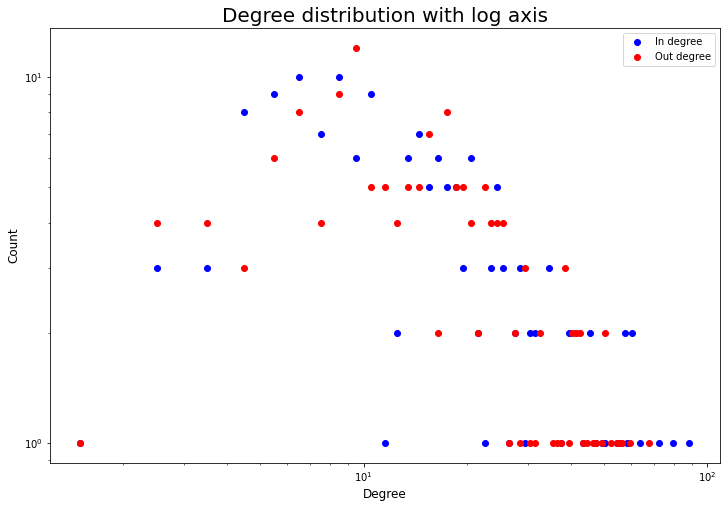

In [8]:
#Create bins and counts
in_degrees = [d for name, d in top5_in_degrees]
hist_in, bins = np.histogram(in_degrees, bins = np.arange(np.min(in_degrees), np.max(in_degrees)+1))
#Compute center of each bin
center_in = (bins[:-1] + bins[1:]) / 2

#Create bins and counts
out_degrees = [d for name, d in top5_out_degrees]
hist_out, bins = np.histogram(out_degrees, bins = np.arange(np.min(out_degrees), np.max(out_degrees)+1))
#Compute center of each bin
center_out = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(12,8))
plt.loglog(center_in, hist_in, '.b', label = "In degree",markersize = 12)
plt.loglog(center_out, hist_out, '.r', label = "Out degree",markersize = 12)
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Degree distribution with log axis', fontsize = 20)
plt.legend()
plt.show()


This could look like a random network, but also somewhat like a scale-free network, and it is hard to determine exactly. Therefore we will look into powerlaw. This is done using the `powerlaw` package which determines the coefficient. 

In [9]:
# To stop unnecessary print messages from the powerlaw package
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    #Compute exponent of in and out-degree distributions
    in_alpha = powerlaw.Fit([G.in_degree(n) for n in G.nodes()],verbose = False).alpha
    out_alpha= powerlaw.Fit([G.out_degree(n) for n in G.nodes()],verbose = False).alpha

print(f"Power law exponent for in degrees: {round(in_alpha,2)}")
print(f"Power law exponent for out degrees: {round(out_alpha,2)}")


Power law exponent for in degrees: 2.56
Power law exponent for out degrees: 3.03


The out-degree coefficient is just above 3 indicating that the network is a random network, but it is quite close to be a scale-free network. The in-degree are below 3 and above 2 which indicates that it is scale-free.

Next, we looking into how the in- and out-degree are correlated, ie. if you are connected to many people in a out-going fashion are these people also connecting to you.

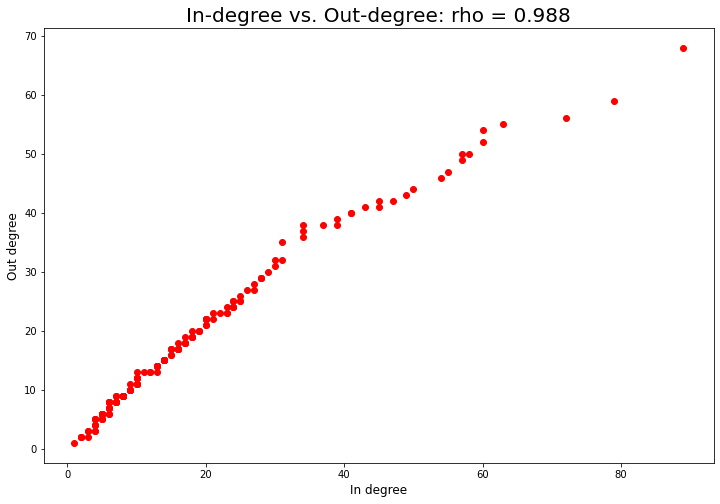

In [10]:
correlation = np.corrcoef([d for name, d in top5_in_degrees],[d for name, d in top5_out_degrees])
plt.figure(figsize = (12,8))
plt.scatter([d for name, d in top5_in_degrees],[d for name, d in top5_out_degrees], color = 'red')
plt.title(f'In-degree vs. Out-degree: rho = {round(correlation[1,0],3)}', fontsize = 20)
plt.xlabel('In degree', fontsize = 12)
plt.ylabel('Out degree', fontsize = 12)
plt.show()

From the plot, we can see that we have a very strong correlation between these connectiveness. 

<h2 align = "center"> 1.3 Attribute interactions </h2>

In this part we are going to investigate how the attributes relate and interact with each other, also it could be that some attributes eg. religion is more well connected than others. We will start out by examining the allegiance attribute. 

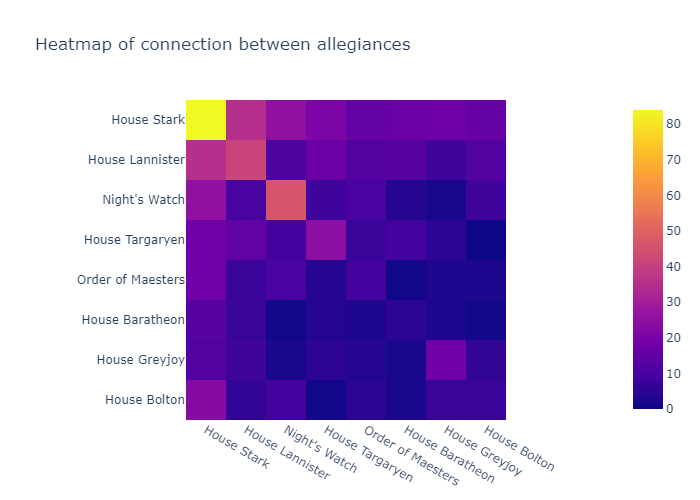

In [11]:
def most_connected_on_attribute(att, n, restrict = False):
    attribute = nx.get_node_attributes(G,att)

    # Get connection between houses and also find most connected houses: 
    connection_dict = {}
    house_connection = {}
    for ef, et in list(G.edges()):
        a_from = attribute[ef]
        a_to = attribute[et]
        
        if a_from == "": continue
        if a_to == "" : continue
        if "No known" in a_from: continue
        if "No known" in a_to: continue
        if a_from in connection_dict.keys():
            house_connection[a_from] += 1
            if a_to in connection_dict[a_from]:
                connection_dict[a_from][a_to] += 1
            else:
                connection_dict[a_from][a_to] = 1
        else:
            house_connection[a_from] = 1
            connection_dict[a_from] = {a_to : 1}
    most_connected_houses = sorted(house_connection, key = lambda i: house_connection[i],reverse = True)[:n]
    tmp = [[house, house_connection[house]] for house in most_connected_houses]
    df_count = pd.DataFrame(tmp, columns = [att.capitalize(), 'Count'])
    fig_count = px.bar(df_count, x = att.capitalize(), y = 'Count', title = "Most connected "+ att)
    
    df_connection = pd.DataFrame.from_dict(connection_dict)
    df_connection = df_connection.fillna(0)

    if restrict:
        df_connection = df_connection.loc[most_connected_houses,most_connected_houses]
        
    fig_heatmap = px.imshow(df_connection, title = "Heatmap of connection between " + str(att)+"s")

    return fig_count, df_count, fig_heatmap, df_connection
    
fig_count, df_count, fig_heatmap, df_connection = most_connected_on_attribute("allegiance",8 ,True)
fig_heatmap.show()

The figure above shows the top 10 most connected allegiances in Game Of Thrones, and it can clearly be seen that *House Stark* is the most connected allegiance, but a lot of the connectivity derives from the interaction with their own allegiance. Further, it can be seen that *House Stark* is well connected with *House Lannister*, *Night's Watch* and *House Bolton*. The connection with *House Lannister* and *Night's Watch* can easily be explained by eg. *Ned Starks'* work as the Kings Hand but also *Sansa Stark* being married with Joffrey. Further, *Jon Snow* from the *House Stark* allegiance are becoming part of *Night's Watch* can explain this interaction.

Generally, it can also be seen that the allegiances interacts with it-self most, compared to interaction with other allegiances. 

Next, we will look into how the religions interact, and from the figure below, it can clearly be seen that the two main religions are the religions that mainly interact with each other, which does not come as a surprise. 

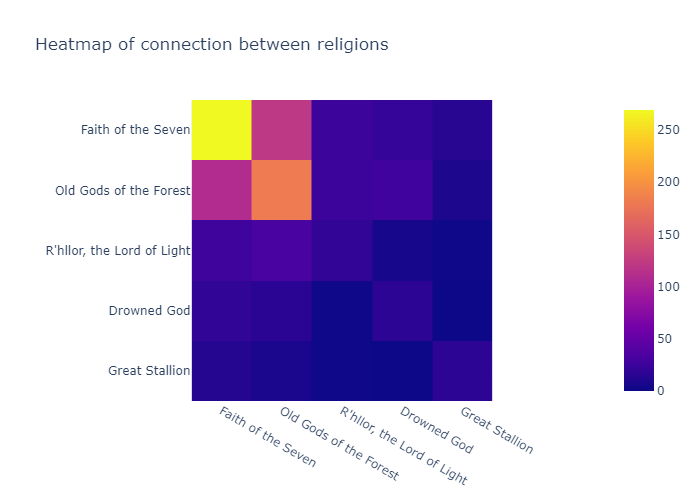

In [12]:
fig_count, df_count, fig_heatmap, df_connection = most_connected_on_attribute("religion",5 ,True)
fig_heatmap.show()

In the figure below, the connection between cultures are investigated. Here it can be seen that the *Andals* are the most connected culture, followed by *Northmen*. Furthermore, it can be seen that these two cultures interact alot. 

It can be seen that the third most connected culture is *Valyrians* which does not mainly interact with themselves, but instead are most connected to *Andals*. 

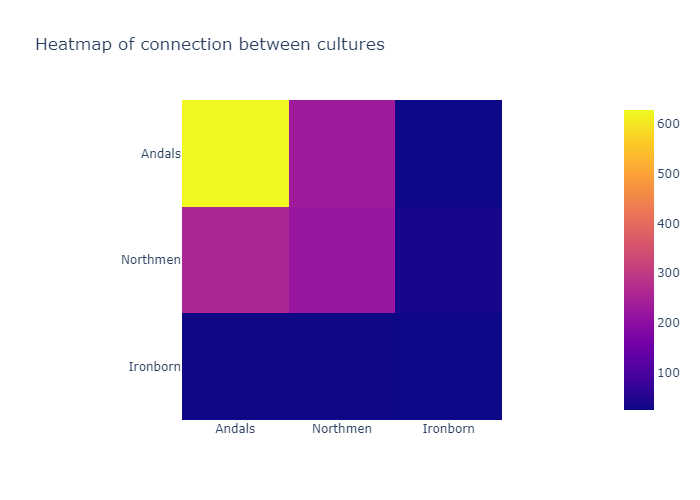

In [13]:
fig_count, df_count, fig_heatmap, df_connection = most_connected_on_attribute("culture",3 ,True)
fig_heatmap.show()

<h1 align = "center"> 2. Visualization of the graph  </h1>

---

This section is devoted to explain how we created our interactive visualization of the network. The app can be found by following this [link](https://gameofthronesnetworknx.herokuapp.com/). The code used to generate the network is found in two separate python files. The file for processing the Game Of Thrones `gpickle` file and creating links and edges can be found [here](https://github.com/MikkelMathiasen23/GameOfThrones_Network/blob/master/network_app/data_methods.py), whereas the python file for the interactive visualization are found [here](https://github.com/MikkelMathiasen23/GameOfThrones_Network/blob/master/network_app/network_app.py). 

The visualization contains a network which is created using `plotly`. Here the `alphas` and `node` sizes are scaled according their respective degree, whereas the `edge` width are scaled according to its frequency. This is done to indicate which nodes are well-connected and has a lot of connections, and further to make the visualizations more easy to understand, as the network is very dense, and can get confusing with all the links. 

The positions of the nodes are computed using `ForceAtlas2` algorithm, where the specific settings can be found in the `compute_positions` function. Further, these positions are saved to speed up the app, as it otherwise needed to recompute these every time, and this also make the figure more reproducible. 

Besides having the network, below are also four "boxes" with information namely: *Season selection, Graph attribute overlay, Click data and Character image*. 

*Season selection* makes it possible to choose whether the network should be based on all data across all seasons for the characters, or whether one wishes to look into a specific season. This makes it possible to investigate which characters are important in each season or across all seasons.

*Graph attribute overlay* are a functionality where one can change the node colour, which is based on the selected attribute. One can select whether the colouring of the nodes should be based on: allegiance, religion or culture. 

*Click data* displays further information about the character when one click on a node. This information is allegiance, culture and religion of the selected attribute, and further a link to the character wiki-page. Further, the top 5 words based on TF-IDF are displayed, how these are computed can be seen in [Text analysis - Notebook](https://github.com/MikkelMathiasen23/GameOfThrones_Network/blob/master/notebooks_final/08_02_text_analysis.ipynb). 

Lastly, *Character image*, as the name says displays the character image which is found using `BeatifulSoup4` which scrapes the character wiki-page and finds the thumbnail image. 

The app is hosted through Heroku, which for free-accounts only have limited ressources, so it might be slow if too many people access it at once. Lastly, the data used to create this visualization is described in the explainer notebook section 2.1.1 where the data are processed and cleaned and saved in `gpickle` files. One file for each season and a file for data across all seasons. The data files can be found [here](https://github.com/MikkelMathiasen23/GameOfThrones_Network/tree/master/data).

The app can be seen below:



<iframe src="https://gameofthronesnetworknx.herokuapp.com/" height = "1200" width = "1000"> </iframe>

<h1 align = "center"> 3. Network properties </h1> 

---

In this section we will look further into properties of the network. This will include clustering, assoritivity and centrality of the network. Which will be described in the sections below. 

Again, only the full network containing all data across seasons is going to be investigated in this section. 
<h2 align= "center" > 3.1 Average clustering </h2> 

We will start out by computing the average clustering coefficient for our network. This can help us understand how many of the possible links each character on average is connected to. 

In [14]:
print(f'The average clustering coefficient is: {nx.average_clustering(G)}')

The average clustering coefficient is: 0.48300137580612906


From this we can see that on average each character is connected to little less than half of the possible links. This would be expected to be pushed up by some of the main characters and down for some of the less important characters. 

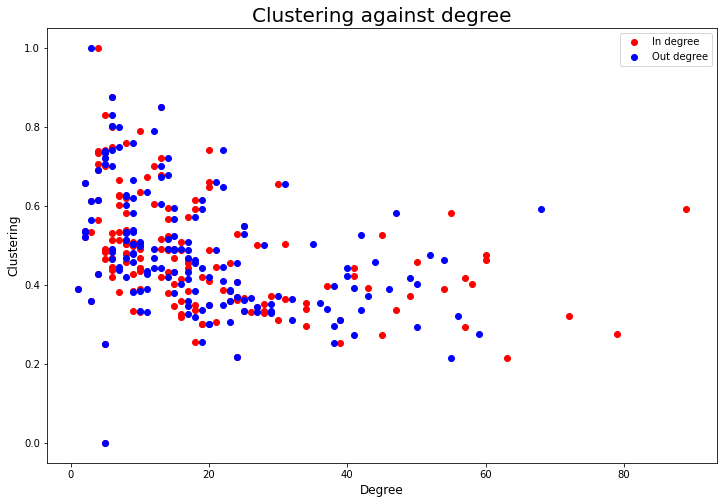

Correlation with in degree: -0.377
Correlation with out degree: -0.412


In [15]:
plt.figure(figsize = (12,8))
plt.scatter([e for n, e in top5_in_degrees],nx.clustering(G).values(), color= 'red', label = 'In degree')
plt.scatter([e for n, e in top5_out_degrees],nx.clustering(G).values(), color= 'blue', label = 'Out degree')
plt.title('Clustering against degree', fontsize = 20)
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('Clustering', fontsize = 12)
plt.legend()
plt.show()
c_in = np.corrcoef([d for name, d in top5_in_degrees],[v for v in nx.clustering(G).values()])
c_out = np.corrcoef([d for name, d in top5_out_degrees],[v for v in nx.clustering(G).values()])
print(f'Correlation with in degree: {round(c_in[1,0],3)}')
print(f'Correlation with out degree: {round(c_out[1,0],3)}')

From the figure above, we can see a slight (very slight) negative correlation between clustering coefficient and the degree (in or out) and the correlation coefficient is approximately -0.5. Meaning character with high in or out-degree has a lower clustering coefficient. 

<h2 align= "center" > 3.2 Assortivity </h2> 

Next we are looking into assortivity of each of our character attributes to see if any of these could indicate whether the characters are linked based on their attribute. This could also help us understand how they are connected, and maybe how we could discover communities in our network. 



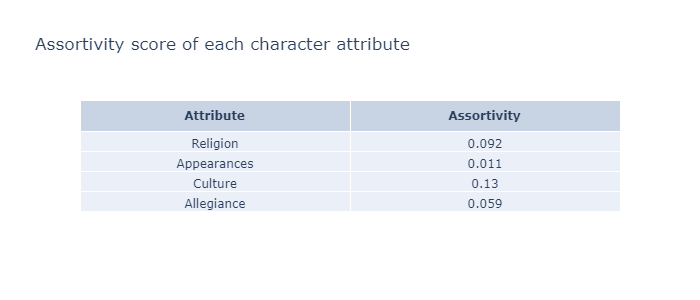

In [16]:
A, assor = [], []
attributes = ["religion", "appearances", "culture", "allegiance"]
for attribute in attributes: 
    A.append(attribute.capitalize())
    assor.append(np.round(nx.attribute_assortativity_coefficient(G, attribute),3))

fig = go.Figure(data=[go.Table(header=dict(values=['<b>Attribute</b>', '<b>Assortivity</b>']),
                 cells=dict(values=[A, assor]))
                     ])
fig.update_layout(
        height=300,
        showlegend=False,
        title_text = "Assortivity score of each character attribute"
    )
fig.show()

From the table above it can be seen that religion has the highest assortivity score, which would indicate that this attribute is the best to distinquish the characters from each other. It should be noted that none of the scores are very high indicating, that the characters are linked in a more complex pattern, or based on another attribute. 

<h2 align = "center"> 3.3 Centrality </h2>

This section is going to investigate different measures of centrality of the full network across all seasons.

<h4 align = "center"> 3.3.1 Closeness centrality </h4>

We are further going to investigate the closeness centrality of each node in the network, which measures the reciprocal sum of shortests paths from the given node to all other nodes. If a node therefore has a high closeness centrality score this means that the node is close to the rest and vice versa. This could give us an indication of well connected characters and further important characters. 

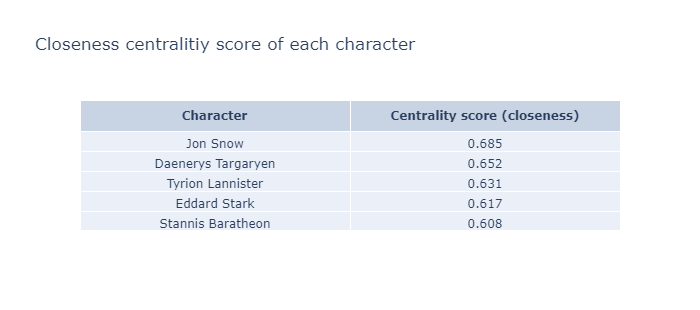

In [17]:
sort_cent = sorted(nx.closeness_centrality(G).items(), key=lambda kv: kv[1], reverse = True)
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Character</b>', '<b>Centrality score (closeness)</b>']),
                 cells=dict(values=[
                     [name[0].replace('_', ' ') for name in sort_cent],
                      [np.round(name[1],3) for name in sort_cent]
                      ]))
                     ])
fig.update_layout(
        height=310,
        showlegend=False,
        title_text = "Closeness centralitiy score of each character"
    )
fig.show()

In the table above the closeness centrality score is computed for all characters and sorted in descending order. As expected it can be seen that *Jon Snow, Daenerys Targaryen* and *Tyrion Lannister* are some of the characters close to the others. Further, *Stannis Baratheon* has a high centrality score, which would make sense as he is involved both as an heir to the throne, but also his involment with the red priest *Mellisandre*. 

Further, *Gregor Clegane, Eddard Stark, Bronn* and the *Night King* has a high centrality score, which does not come as a surprise as these are key characters in the story, and interacts with many characters. In the bottom some of the smaller characters such as *Ray* and *Aeron Greyjoy* are present. 

From this it could appear that character with a high degree also has a high closeness centralitity. This are we going to visualize in a scatter plot below and as well compute correlation coefficients for both in- and out-degree. 

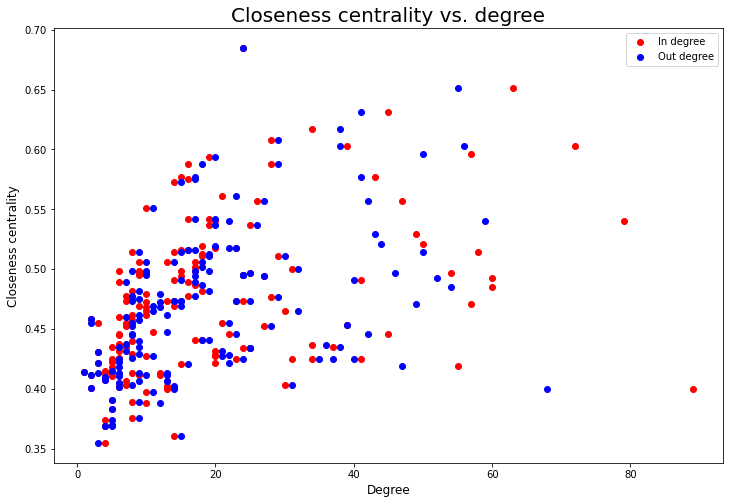

Correlation with in degree: 0.426
Correlation with out degree: 0.459


In [18]:
plt.figure(figsize = (12,8))
plt.scatter([e for n, e in top5_in_degrees],nx.closeness_centrality(G).values(), color= 'red', label = 'In degree')
plt.scatter([e for n, e in top5_out_degrees],nx.closeness_centrality(G).values(), color= 'blue', label = 'Out degree')
plt.title('Closeness centrality vs. degree', fontsize = 20)
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('Closeness centrality', fontsize = 12)
plt.legend()
plt.show()
c_in = np.corrcoef([d for name, d in top5_in_degrees],[v for v in nx.closeness_centrality(G).values()])
c_out = np.corrcoef([d for name, d in top5_out_degrees],[v for v in nx.closeness_centrality(G).values()])
print(f'Correlation with in degree: {round(c_in[1,0],3)}')
print(f'Correlation with out degree: {round(c_out[1,0],3)}')

From the above it can be seen that there are only some slight correlation between in- and out-degree and closeness centrality. We can see in general that it appears when a character has high degree also have high closeness centrality, but a few characters with very high degree interfer with this tendency.

<h4 align = "center"> 3.3.2 Eigenvector centrality </h4>

We are now going to compute the eigenvector centrality for each character in the network. The eigenvector centrality is based on the centrality of its neighbors. 

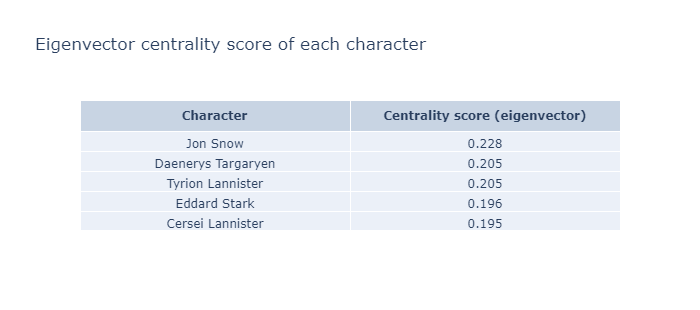

In [19]:
sort_cent = sorted(nx.eigenvector_centrality(G).items(), key=lambda kv: kv[1], reverse = True)
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Character</b>', '<b>Centrality score (eigenvector)</b>']),
                 cells=dict(values=[
                     [name[0].replace('_', ' ') for name in sort_cent],
                      [np.round(name[1],3) for name in sort_cent]
                      ]))
                     ])
fig.update_layout(
        height=310,
        showlegend=False,
        title_text = "Eigenvector centrality score of each character"
    )
fig.show()

Again, we notice that main characters has the highest eigenvector centrality score, and almost the same characters are in top 5. Further, the largest eigenvector centrality is 0.228 which is Jon Snow. 

Again, we will visualize the centrality vs. the in and out-degree to see if there are any correlation. 

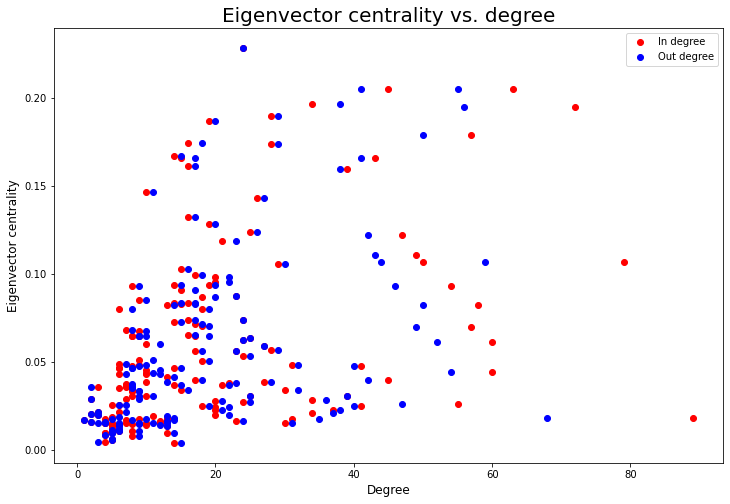

Correlation with in degree: 0.414
Correlation with out degree: 0.438


In [20]:
plt.figure(figsize = (12,8))
plt.scatter([e for n, e in top5_in_degrees],nx.eigenvector_centrality(G).values(), color= 'red', label = 'In degree')
plt.scatter([e for n, e in top5_out_degrees],nx.eigenvector_centrality(G).values(), color= 'blue', label = 'Out degree')
plt.title('Eigenvector centrality vs. degree', fontsize = 20)
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('Eigenvector centrality', fontsize = 12)
plt.legend()
plt.show()
c_in = np.corrcoef([d for name, d in top5_in_degrees],[v for v in nx.eigenvector_centrality(G).values()])
c_out = np.corrcoef([d for name, d in top5_out_degrees],[v for v in nx.eigenvector_centrality(G).values()])
print(f'Correlation with in degree: {round(c_in[1,0],3)}')
print(f'Correlation with out degree: {round(c_out[1,0],3)}')

The result is very similar to the one achieved by using the closeness centrality measure. Again we see some correlation between the degree and the eigenvector centrality. When the degree is increasing the variation in eigenvector centrality appears to increase as well. 

<h4 align = "center"> 3.3.4 Betweenness centrality </h4>

As a last metric of centrality we will investigate the betweenness centrality, which is estimated as the sum of the fraction of all shortest paths that passes through the given node.

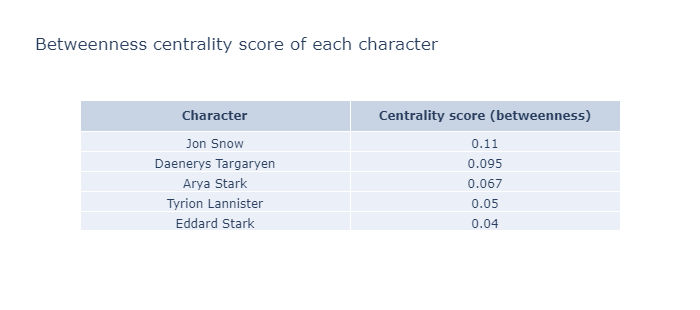

In [21]:
sort_cent = sorted(nx.betweenness_centrality(G).items(), key=lambda kv: kv[1], reverse = True)
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Character</b>', '<b>Centrality score (betweenness)</b>']),
                 cells=dict(values=[
                     [name[0].replace('_', ' ') for name in sort_cent],
                      [np.round(name[1],3) for name in sort_cent]
                      ]))
                     ])
fig.update_layout(
        height=310,
        showlegend=False,
        title_text = "Betweenness centrality score of each character"
    )
fig.show()

Again, the characters in top 5 are almost the same, and the highest betweenness centrality is 0.11 assigned to Jon Snow. We are again going to investigate the correlation between the betweenness centrality and degree (in and out).

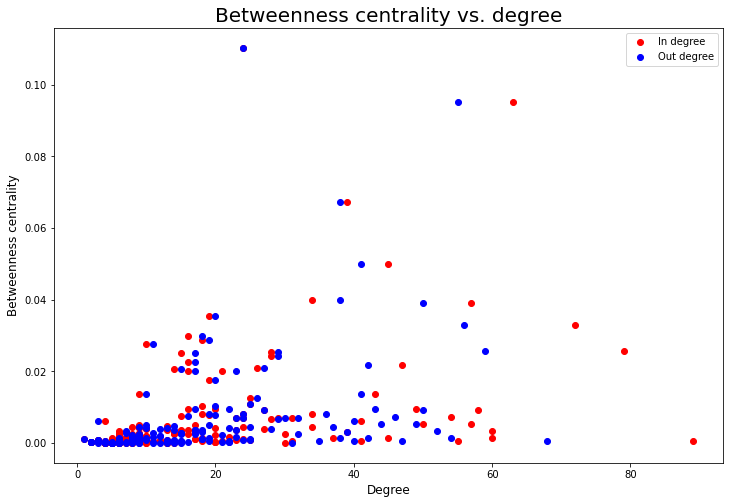

Correlation with in degree: 0.379
Correlation with out degree: 0.391


In [22]:
plt.figure(figsize = (12,8))
plt.scatter([e for n, e in top5_in_degrees],nx.betweenness_centrality(G).values(), color= 'red', label = 'In degree')
plt.scatter([e for n, e in top5_out_degrees],nx.betweenness_centrality(G).values(), color= 'blue', label = 'Out degree')
plt.title('Betweenness centrality vs. degree', fontsize = 20)
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('Betweenness centrality', fontsize = 12)
plt.legend()
plt.show()
c_in = np.corrcoef([d for name, d in top5_in_degrees],[v for v in nx.betweenness_centrality(G).values()])
c_out = np.corrcoef([d for name, d in top5_out_degrees],[v for v in nx.betweenness_centrality(G).values()])
print(f'Correlation with in degree: {round(c_in[1,0],3)}')
print(f'Correlation with out degree: {round(c_out[1,0],3)}')

We can see that the centrality score in general are lower, and a few points are pulling the tendency up whereas most are quite low. The corerlation coefficients are again quite low only between 0.38-0.39.

<h2 align = "center"> 3.4 VoteRank </h2>

As a last property of the network we are going to investigate the VoteRank of the network. We are going to use the VoteRank algorithm to find a number of important nodes. The VoteRank algorithm computes a ranking for all nodes in the network in an iterative manner, where each node vote for it in-neighbors and the node with the laregst amount of votes are selected. The selected nodes effect on the voting are decreased iteratively, so they dont keep influencing the algorithm.

We are going to find the top 5 characters based on the VoteRank algorithm using the `voterank` function. 

In [23]:
ranked = [name.replace('_',' ') for name in nx.voterank(G,5)]

print(f'Top 5 most important characters based on the VoteRank algorithm: \n  {ranked}')

Top 5 most important characters based on the VoteRank algorithm: 
  ['Jon Snow', 'Sansa Stark', 'Tyrion Lannister', 'Arya Stark', 'Jaime Lannister']


Again, Jon Snow appear to be the most important character. The other characters are also main characters from the series, so it would make sense they are part of being the most important. 

<h1 align = "center"> 4. Important characters for each season</h1>

---

This section is devoted to explain how we did create our interactive visualization of the character degree and centrality measures. The app can be found by following this [link](https://gameofthronestables.herokuapp.com/). As Heroku only makes it possible to host one app pr. Github repository the code are uploaded to a separate Github repository, which can be found [here](https://github.com/MikkelMathiasen23/GameOfThrones_table). 

The code can be found in this python [file](https://github.com/MikkelMathiasen23/GameOfThrones_table/blob/main/table_graf.py). The app contain three main parts: the season tabs which is created using `dash_core_components.Tabs`, the table which is create using `dash_table.DataTable`, where it has been selected to include functionalities such as deleting columns and rows, sorting and filtering the data. The last component is the barplots below the table which also responds to sorting, filtering and deletions. 

The idea with the table is to make it possible for the end user to go through the seasons and investigate what characters are most connected and have the highest centrality score. Instead of listing 8 tables we thought this were a more engaging and nice way to do it. 

In order to generate the needed data, we did iterate through all seasons and loaded the `gpickle` file for the given season, computed closeness centrality, in- and out-degree for each character and saved it in a dataframe. 

All the dataframes were saved in a dictionary which were saved in a `pickle` that could be loaded by the app. The code for generating the`pickle` file can be seen below.

In [24]:
tables = {}

#Iterate through each season:
for i in range(1,9):
    #Load network
    G = nx.read_gpickle("../data/got_G_s"+str(i)+".gpickle")

    #Compute out centrality:
    centrality = nx.closeness_centrality(G)    

    #Store in, out, centrality and character name in list of lists
    att = [[n.replace('_',' '),G.in_degree(n), G.out_degree(n), np.round(centrality[n],3)] for n, d in G.nodes(data = True)]

    #Save to dataframe and rename columns
    df = pd.DataFrame(att)
    df.columns = ['Character name', 'In degree', 'Out degree', 'Closeness centrality']
    #Save in dictionary:
    tables[i] = df
import pickle

#Save pickle file
with open('../data/tables.pickle', 'wb') as handle:
    pickle.dump(tables, handle, protocol=pickle.HIGHEST_PROTOCOL)

The running app can be seen below:

<iframe src="https://gameofthronestables.herokuapp.com/" width = "1000" height = "1000"> </iframe>

From the table it can be seen that the most connected and maybe important characters in season 1 might be *Eddard Stark* and *Robert Baratheon*, which makes perfect sense as Eddard is present a lot in season 1, both in Winterfell but also when he becomes the Kings hand. Robert is also very central in season 1, as he rules as King and dies when hunting - *killed by a pig*, as he says it. 

Season 2, here *Joffrey Baratheon*, the new king, rules, and *Robb Stark* goes to war as he wants revenge for his fathers execution in season 1. 

Later, in season 7 *Jon Snow*  and *Daenerys Targaryen* becomes key players as the winter is approaching and the focus moves from Kings Landing to the wall and the fight against the dead. 

<h1 align = "center"> 5. Subconclusion </h1>

---
The resulting graph across all seasons were a very dense graph, and through different network analysis tools and by splitting into seasons it was possible to determine the most important characters in each season. Further, we found that the character attributes selected (religion, culture, allegiance, appearance and status) did not pose to be good measures to distinguish the characters. The characters were possibly connected base on another attribute or underlying pattern. 

In the next sections we are going to investigate community analysis and hopefully this can help us reveal some of these patterns. 